# FRET Burst Variance Analysis

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from typing import Dict, Any, Union, List, Tuple

import numpy as np
import pandas as pd

import pylab as plt

import pathlib
import tttrlib

import chisurf
import chisurf.fio as io
import chisurf.fluorescence

def average_histogram(
    counts: np.ndarray,
    x_bins: np.ndarray,
    y_bins: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute the mean and the sd over the bins of a 2D histogram
    """
    mean = list()
    sd = list()
    h = counts
    y = y_bins[1:]
    y2 = y * y
    x = x_bins[1:]
    for i, prox in enumerate(x):
        c = h[i]
        s = np.sum(c)
        m1 = c @ y / s
        m2 = c @ y2 / s
        mean.append(m1)
        v = np.sqrt(m2 - m1*m1) / np.sqrt(s)
        sd.append(v)
    sd = np.array(sd)
    mean = np.array(mean)
    return mean, sd


def run_bva(
    paris_path,
    file_type,
    bva_settings,
):
    df, tttrs = io.fluorescence.burst.read_burst_analysis(paris_path, file_type)
    
    plt.title('Bust duration')
    counts, bins, patches =  plt.hist(df['Duration (ms)'], bins=np.linspace(0, 60, 31), log=False, rwidth=0.6, linewidth=1., edgecolor='black', fc=(0.1, 0.1, 0.1, 0.2))
    plt.xlabel('Duration (ms)')
    plt.ylabel('Counts')
    
    df = chisurf.fluorescence.burst.compute_bva(df, tttrs, **bva_settings)
    # Make plot
    plt.title('Burst variance analysis')
    plt.xlabel('Mean proximity ratio, M(PR)')
    plt.ylabel('PR standard deviation, SD(PR)')
    [xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.5)
    bins = 31, 31
    vmin, vmax = 0.5, 100
    df_selected = df[df['Proximity Ratio Std'] > 0.0]
    counts, prox_mean_bins, prox_sd_bins, _ = plt.hist2d(
        df_selected['Proximity Ratio Mean'], df_selected['Proximity Ratio Std'], 
        range=[[xmin, xmax], [ymin, ymax]], 
        bins=bins, vmin=vmin, vmax=vmax,
        cmap='magma'
    )
    
    prox_mean_sim, prox_sd_sim = chisurf.fluorescence.burst.compute_static_bva_line(prox_mean_bins, bva_settings['number_of_photons_per_slice'])
    mean, sd = average_histogram(counts, prox_mean_bins, prox_sd_bins)
    plt.plot(prox_mean_sim, prox_sd_sim, 'w')
    _ = plt.errorbar(prox_mean_bins[1:], mean, yerr=sd, fmt='ob', alpha=0.3)
    io.fluorescence.burst.write_bv4_analysis(df, paris_path)

## Select analysis folder
First, select the file type and the burst analysis folder (typically named "burstwise_All 0.1500#60," where 0.1500 and 60 represent selection thresholds). This folder should contain a set of burst files located in the 'bi4_bur' subfolder, which hold the indices of the selected bursts.

Second, define the micro time ranges for the donor and acceptor windows. This step is particularly important for pulsed interleaved excitation (PIE) experiments.

Third, specify the minimum size of the time slice or window within each burst. If number_of_photons_per_slice is set to -1, the burst will be divided into equal time intervals of length minimum_window_length.

Finally, execute the cell below the input widgets. Execution of the cell will create a BVA histogram as a preview and writes the BVA analysis into the 'bv4' subfolder of the burst analysis folder.

In [ ]:
# Example dictionary with annotated types
bva_settings: Dict[str, Union[List[int], List[Tuple[int, int]], float, int]] = {
    "donor_channels": [0, 8],
    "donor_micro_time_ranges": [(0, 32768)],
    "acceptor_channels": [1, 9],
    "acceptor_micro_time_ranges": [(0, 32768)],
    "minimum_window_length": 0.01,
    "number_of_photons_per_slice": 10
}
analysis_folder = pathlib.Path()

In [22]:
import ipyfilechooser
import ipywidgets as widgets
from IPython.display import display

ft_w = widgets.Dropdown(
    options=["SPC-130", "PTU", "HT3", "sm"],
    value='SPC-130',
    description='File type:',
    disabled=False,
)
display(ft_w)

# Create a file chooser widget
file_chooser = ipyfilechooser.FileChooser(pathlib.Path.home())  # Set an initial directory

# Display the file chooser
display(file_chooser)

import ipywidgets as widgets

# Helper function to convert comma-separated strings to a list of integers
def comma_separated_to_list(s: str) -> List[int]:
    return [int(x.strip()) for x in s.split(',') if x.strip().isdigit()]

# Function to map types to widget constructors
def dict_to_widgets(d: Dict[str, Any]) -> widgets.VBox:
    widget_dict = {}
    
    for key, value in d.items():
        if "channels" in key:  # Use Text input for channels (comma-separated values)
            widget = widgets.Text(value=", ".join(map(str, value)), description=key)
        elif "ranges" in key and isinstance(value, list) and isinstance(value[0], tuple):  # Use sliders for ranges
            min_val, max_val = value[0]
            widget = widgets.IntRangeSlider(value=(min_val, max_val), min=min_val, max=max_val, step=1, description=key)
        elif isinstance(value, int):
            widget = widgets.IntText(value=value, description=key)
        elif isinstance(value, float):
            widget = widgets.FloatText(value=value, description=key)
        elif isinstance(value, str):
            widget = widgets.Text(value=value, description=key)
        elif isinstance(value, bool):
            widget = widgets.Checkbox(value=value, description=key)
        else:
            widget = widgets.Text(value=str(value), description=key)
        
        # Store the widget in the dictionary with its corresponding key
        widget_dict[key] = widget
    
    # Return a VBox to display the widgets, and the widget_dict to access values later
    return widgets.VBox(list(widget_dict.values())), widget_dict

# Example dictionary with annotated types
bva_settings: Dict[str, Union[List[int], List[Tuple[int, int]], float, int]] = {
    "donor_channels": [0, 8],
    "donor_micro_time_ranges": [(0, 32768)],
    "acceptor_channels": [1, 9],
    "acceptor_micro_time_ranges": [(0, 32768)],
    "minimum_window_length": 0.01,
    "number_of_photons_per_slice": 10
}

# Convert dictionary to widgets
widget_box, widget_dict = dict_to_widgets(bva_settings)

# Display the widgets
display(widget_box)

# Function to get the current values from the widgets
def get_widget_values(widget_dict: Dict[str, widgets.Widget]) -> Dict[str, Any]:
    current_values = {}
    
    for key, widget in widget_dict.items():
        if "channels" in key:  # Convert comma-separated values back to a list of integers
            current_values[key] = comma_separated_to_list(widget.value)
        elif "ranges" in key and isinstance(widget, widgets.IntRangeSlider):  # Extract the range slider values
            current_values[key] = [(widget.value[0], widget.value[1])]
        else:
            current_values[key] = widget.value  # For other types, just use .value
        
    return current_values

# Access the widget values after user input
current_values = get_widget_values(widget_dict)

Dropdown(description='File type:', options=('SPC-130', 'PTU', 'HT3', 'sm'), value='SPC-130')

FileChooser(path='/Users/tpeulen', filename='', title='', show_hidden=False, select_desc='Select', change_desc…

100%|██████████| 9027/9027 [00:09<00:00, 949.40it/s] 


BVA results have been written to .bv4 files in the '/Users/tpeulen/dev/tttr-data/bh/bh_spc132_sm_dna/burstwise_All 0.1500#60/bv4' directory.


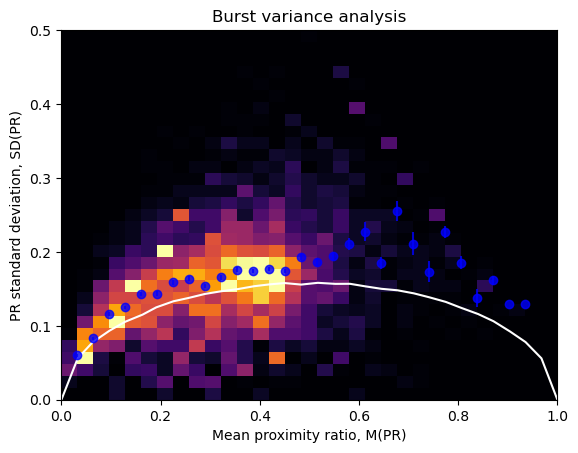

In [47]:
# Read settings from widgets
analysis_folder = pathlib.Path(file_chooser.value)
settings = get_widget_values(widget_dict)

# Read bur files
df, tttrs = io.fluorescence.burst.read_burst_analysis(analysis_folder, ft_w.value)

# Perform BVA
df = chisurf.fluorescence.burst.bva.compute_bva(df, tttrs, **settings)

# Discriminate Bursts
df_selected = df[df['Proximity Ratio Std'] > 0.0]

# Make BVA plot
plt.title('Burst variance analysis')
plt.xlabel('Mean proximity ratio, M(PR)')
plt.ylabel('PR standard deviation, SD(PR)')
[xmin, xmax], [ymin, ymax] = (0, 1), (0, 0.5)
bins = 31, 31
vmin, vmax = 0.1, 60
counts, prox_mean_bins, prox_sd_bins, _ = plt.hist2d(
    df_selected['Proximity Ratio Mean'], df_selected['Proximity Ratio Std'], 
    range=[[xmin, xmax], [ymin, ymax]], 
    bins=bins, vmin=vmin, vmax=vmax,
    cmap='inferno'
)
plt.plot(
    *chisurf.fluorescence.burst.compute_static_bva_line(
        prox_mean_bins, number_of_photons_per_slice=settings['number_of_photons_per_slice']
    ), 'w'
)

mean, sd = average_histogram(counts, prox_mean_bins, prox_sd_bins)
_ = plt.errorbar(prox_mean_bins[1:], mean, yerr=sd, fmt='ob', alpha=0.8)

# Write bv4 files
io.fluorescence.burst.write_bv4_analysis(df, analysis_folder)

## Compute mean an variance for simulated static species

In BVA, the expected standard deviation of a static species is influenced by the number of photons in a slice, as illustrated in the figure below. Therefore, adjust the parameters to your experiments.

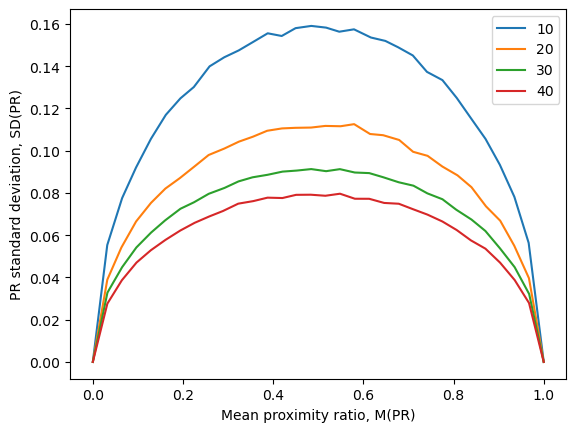

In [48]:
plt.xlabel('Mean proximity ratio, M(PR)')
plt.ylabel('PR standard deviation, SD(PR)')
for n in [10, 20, 30, 40]:
    plt.plot(*chisurf.fluorescence.burst.compute_static_bva_line(prox_mean_bins, number_of_photons_per_slice=n), label=n)
plt.legend()